https://pysdr.org/content/sync.html

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

In [12]:
num_symbols = 100
sps = 8 # samples per symbol
rng = np.random.default_rng(7) # seed for reproducibility
bits = rng.integers(0, 2, num_symbols)

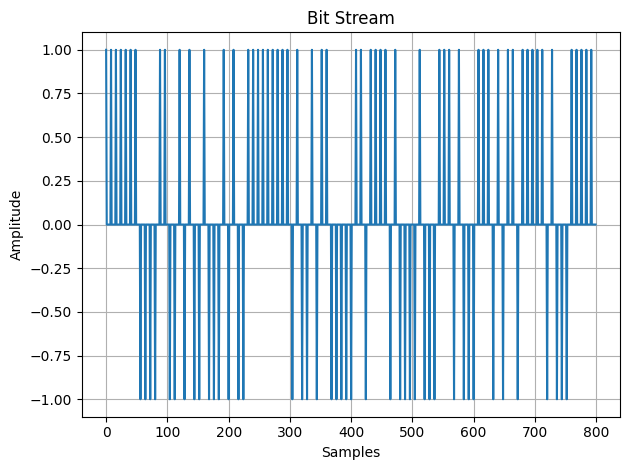

In [13]:
# Create bit sequence
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

plt.figure()
plt.plot(pulse_train)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Bit Stream")
plt.grid()
plt.tight_layout()
plt.show()

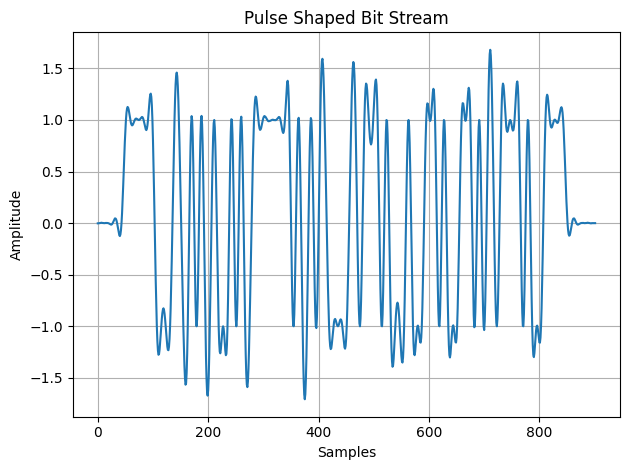

In [14]:
# Create raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so symbol period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

samples = np.convolve(pulse_train, h)

plt.figure()
plt.plot(samples)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Pulse Shaped Bit Stream")
plt.grid()
plt.tight_layout()
plt.show()

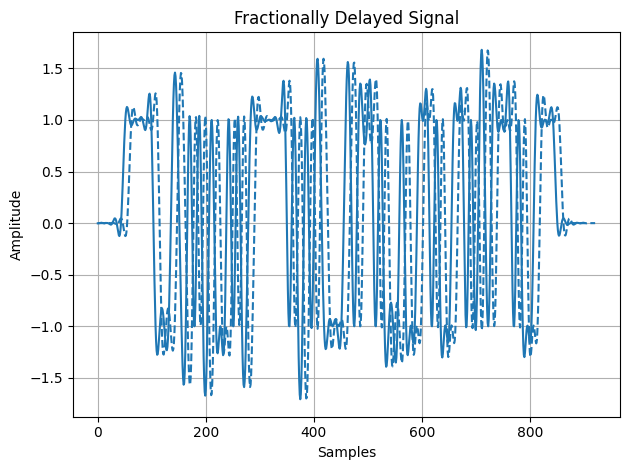

In [5]:
# Create and apply fractional delay filter
delay = 0.4 # fractional delay, in samples
N = 21 # number of taps
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
samples_delayed = np.convolve(samples, h) # apply filter

plt.figure()
plt.plot(samples, color = 'tab:blue')
plt.plot(samples_delayed, color = 'tab:blue', linestyle='--')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Fractionally Delayed Signal")
plt.grid()
plt.tight_layout()
plt.show()

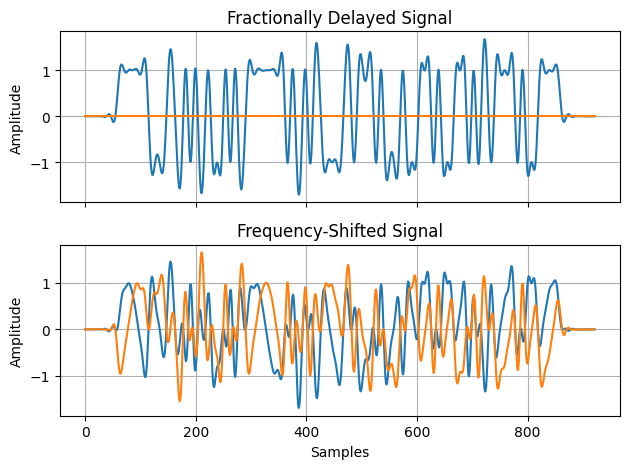

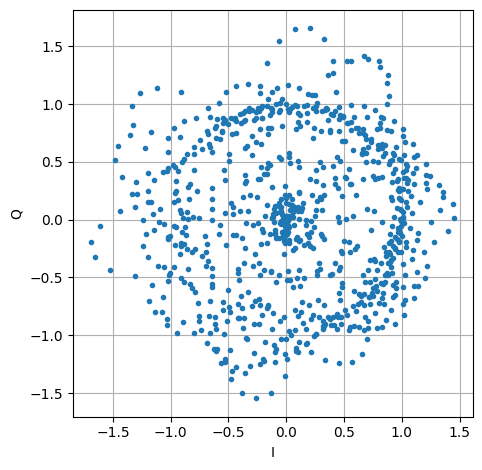

In [20]:
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 13000 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples_delayed), Ts) # create time vector
samples_freq_offset = samples_delayed * np.exp(1j*2*np.pi*fo*t) # perform freq shift

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(np.real(samples_delayed))
ax[0].plot(np.imag(samples_delayed))
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Fractionally Delayed Signal")
ax[0].grid()
ax[1].plot(np.real(samples_freq_offset))
ax[1].plot(np.imag(samples_freq_offset))
ax[1].set_xlabel("Samples")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Frequency-Shifted Signal")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.real(samples_freq_offset), np.imag(samples_freq_offset), '.')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("I")
plt.ylabel("Q")
plt.grid()
plt.tight_layout()
plt.show()

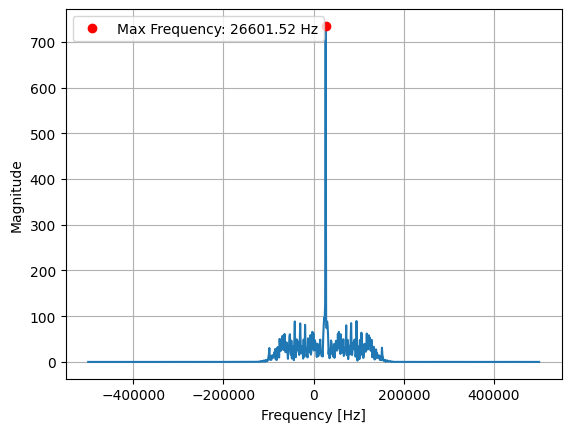

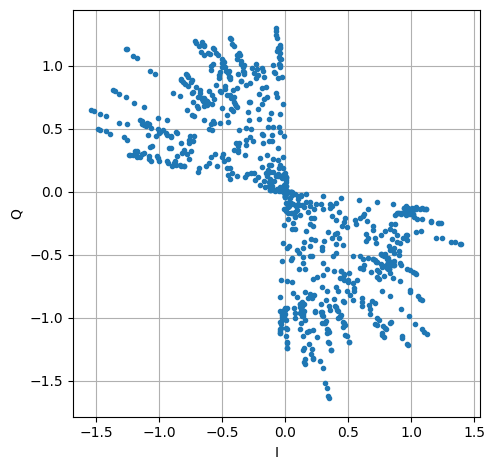

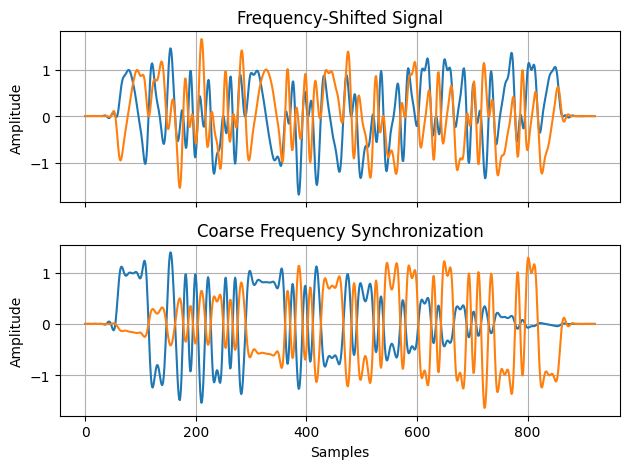

In [21]:
samples_freq_offset_squared = samples_freq_offset ** 2
psd = np.fft.fftshift(np.abs(np.fft.fft(samples_freq_offset_squared)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
max_freq = f[np.argmax(psd)]
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples_freq_offset_squared), Ts) # create time vector
samples_cfo = samples_freq_offset * np.exp(-1j*2*np.pi*max_freq*t/2.0)

plt.plot(f, psd)
plt.plot(max_freq, np.max(psd), 'ro', label=f"Max Frequency: {max_freq:.2f} Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(np.real(samples_cfo), np.imag(samples_cfo), '.')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("I")
plt.ylabel("Q")
plt.grid()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(np.real(samples_freq_offset))
ax[0].plot(np.imag(samples_freq_offset))
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Frequency-Shifted Signal")
ax[0].grid()
ax[1].plot(np.real(samples_cfo))
ax[1].plot(np.imag(samples_cfo))
ax[1].set_xlabel("Samples")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Coarse Frequency Synchronization")
plt.grid()
plt.tight_layout()
plt.show()

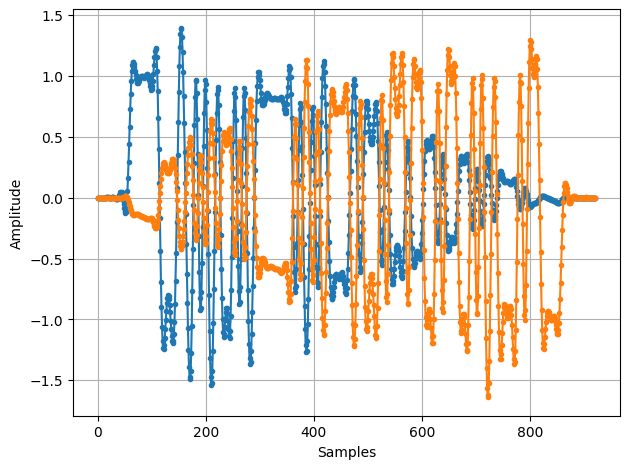

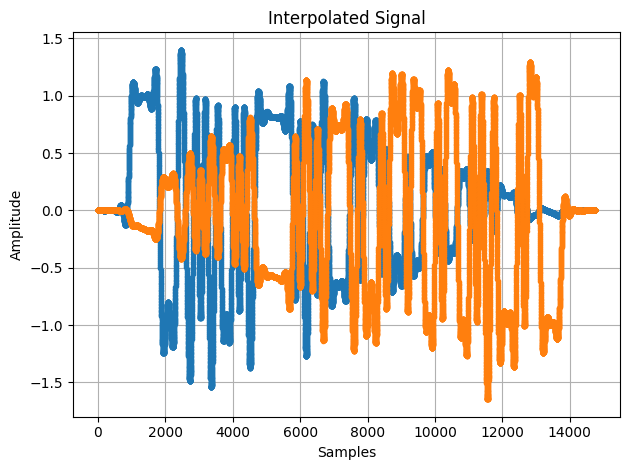

In [22]:
samples_interpolated = signal.resample_poly(samples_cfo, 16, 1)

# Plot the old vs new
plt.figure()
plt.plot(np.real(samples_cfo),'.-')
plt.plot(np.imag(samples_cfo),'.-')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.real(samples_interpolated),'.-')
plt.plot(np.imag(samples_interpolated), '.-')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Interpolated Signal")
plt.grid()
plt.tight_layout()
plt.show()

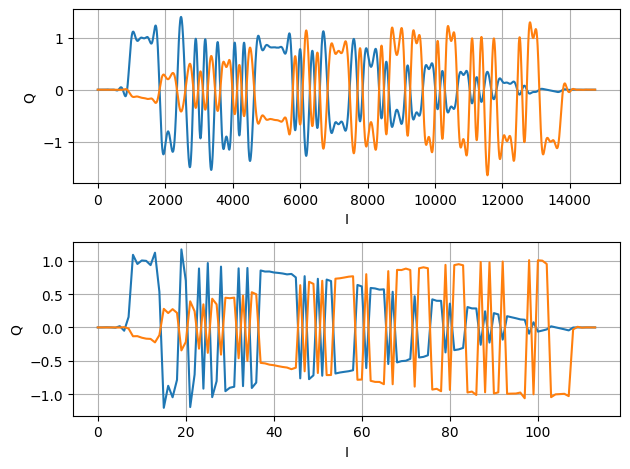

In [23]:
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples_cfo) + 10, dtype=np.complex64)
out_rail = np.zeros(len(samples_cfo) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples_cfo) and i_in+16 < len(samples_cfo):
    out[i_out] = samples_interpolated[i_in*16 + int(mu*16)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples_time_sync = out # only include this line if you want to connect this code snippet with the Costas Loop later on

fig, ax = plt.subplots(2, 1)
ax[0].plot(np.real(samples_interpolated))
ax[0].plot(np.imag(samples_interpolated))
ax[0].set_xlabel("I")
ax[0].set_ylabel("Q")
ax[0].grid()

ax[1].plot(np.real(samples_time_sync))
ax[1].plot(np.imag(samples_time_sync))
ax[1].set_xlabel("I")
ax[1].set_ylabel("Q")
ax[1].grid()

plt.tight_layout()
plt.show()

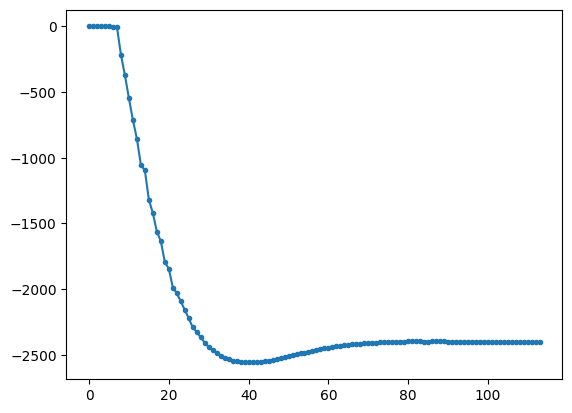

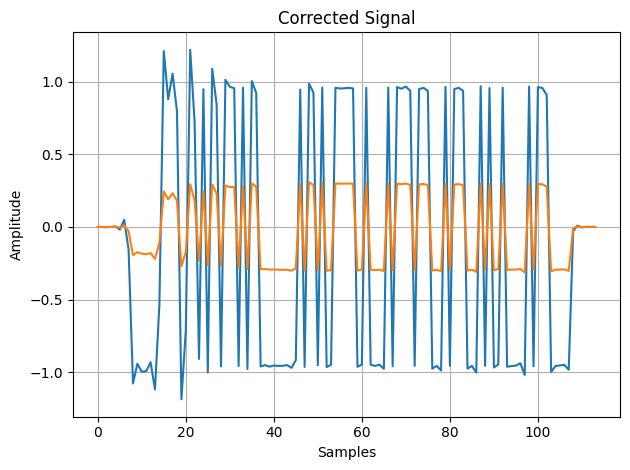

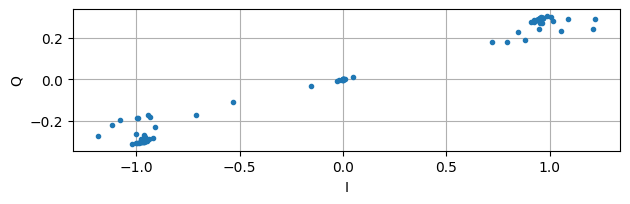

In [24]:
N = len(samples_time_sync)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 0.132
beta = 0.00932
out = np.zeros(N, dtype=np.complex64)
freq_log = []
for i in range(N):
    out[i] = samples_time_sync[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

samples_corrected = out * np.exp(-1j*2*phase)


# Plot freq over time to see how long it takes to hit the right offset
plt.plot(freq_log,'.-')
plt.show()

plt.plot(np.real(samples_corrected))
plt.plot(np.imag(samples_corrected))
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Corrected Signal")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.real(samples_corrected), np.imag(samples_corrected), '.')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("I")
plt.ylabel("Q")
plt.grid()
plt.tight_layout()
plt.show()